In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl
import numpy as np
import scipy

import pymc as pm
import arviz as az

import warnings

sns.set(rc={'figure.figsize':(17,11)})

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pl.read_parquet("../data/counter_data.parquet").with_columns(pl.col("weekday") - 1)

In [3]:
data.select(pl.col("site_name").unique()).to_numpy()

array([['Willis St'],
       ['Adelaide Road'],
       ['Glenmore Street'],
       ['Tawa Shared Path (Southern end)'],
       ['Tawa Shared Path (At Kenepuru)'],
       ['Crawford'],
       ['Evans Bay'],
       ['Tasman Street'],
       ['Cobham Drive Shared Path'],
       ['Oriental Parade Shared Path'],
       ['Oriental Cycle Sign Virtual 2 Bins'],
       ['Evans Bay Shared Path'],
       ['Mt Vic Tunnel'],
       ['Salamanca Road'],
       ['Brooklyn Road - up hill'],
       ['Willowbank'],
       ['Oriental Road'],
       ['Burma Road'],
       ['Hutt Road Shared Path'],
       ['Thorndon Quay'],
       ['Basin Reserve'],
       ['Hutt Road Cycle Sign Virtual'],
       ['Airport Tunnel Counter']], dtype=object)

In [4]:
filtered_data = data.filter(
    (pl.col("year") == 2022) &
    (pl.col("site_name") == "Thorndon Quay") &
    (pl.col("weekday") < 5)
)

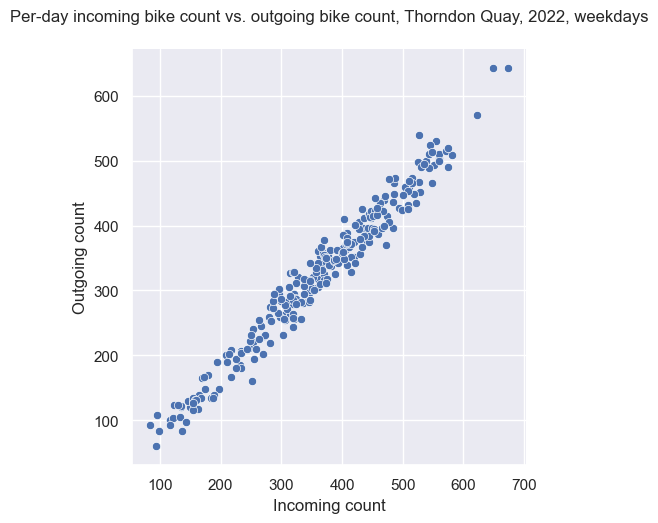

In [5]:
sns.relplot(
    filtered_data.set_sorted(pl.col("record_time")).group_by_dynamic(pl.col("record_time"), every="1d").agg(
        pl.col("count_incoming").sum(),
        pl.col("count_outgoing").sum()
    ),
    x="count_incoming",
    y="count_outgoing"
)
plt.xlabel("Incoming count")
plt.ylabel("Outgoing count")
plt.title("Per-day incoming bike count vs. outgoing bike count, Thorndon Quay, 2022, weekdays", pad=20);
plt.show()

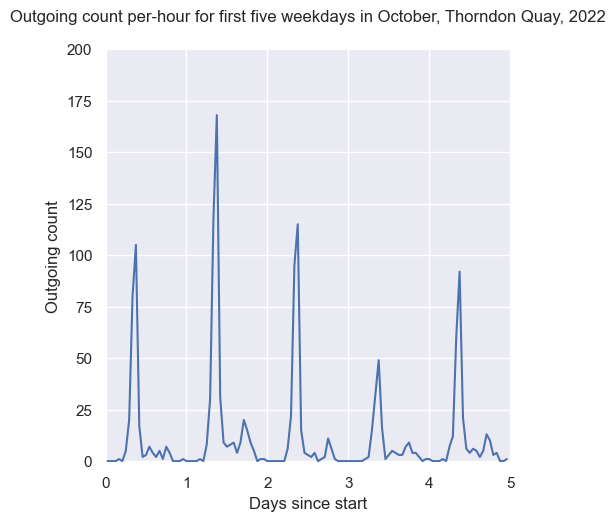

In [6]:
sns.relplot(
    (
        filtered_data.filter(
            (pl.col("month") == 10) &
            (pl.col("day") <= 7)
        )
        .with_columns(
            (pl.col("weekday") * 24 + pl.col("hour")).alias("day_hour")
        )
    ), 
    x="day_hour", 
    y="count_outgoing",
    kind="line"
)
plt.xlabel("Days since start")
plt.ylabel("Outgoing count")
plt.ylim(-1,200)
plt.xlim(0,24*5)
plt.xticks([24*i for i in range(6)], list(range(6)))
plt.title("Outgoing count per-hour for first five weekdays in October, Thorndon Quay, 2022", pad=20);

Model describes bike count $c_i$ as GammaPoisson distribution conditional on time of day, for data sampled where: 

- location = "Thorndon Quay"
- year = 2022
- day = {monday, tuesday, wednesday, thursday, friday}
- direction = "Outgoing"

$hour[i]$ is indexed hour of day for sample $i$, with "12am-1am" = 0. 

\begin{align}
c_i &\sim GammaPoisson(\phi, \mu_i) \\
\log{(\mu_i)} &= \lambda_{hour[i]} \\
\lambda_{j = 0..23} &\sim MVNormal([0,0,\dots,0]^T, K) \\
K &= Periodic(24, \tau) \\
\phi &\sim Exponential(1) \\
\tau &\sim Exponential(0.1)
\end{align}

In [7]:
with pm.Model() as m_1:
    hour = pm.MutableData("hour", np.array(filtered_data["hour"]), dims="obs_id")
    
    # Per-hour effect
    tau = pm.Exponential("tau", scale=0.1)
    cov = pm.gp.cov.Periodic(1, period=24, ls=tau)
    cov += pm.gp.cov.WhiteNoise(1e-4)
    K = cov(np.arange(24)[:, None]).eval()
    
    alpha_h = pm.MvNormal("alpha_h", mu=np.zeros(len(K)), cov=K, shape=len(K))
    lmda_h = pm.Deterministic("lmda_h", np.exp(alpha_h))
    
    phi = pm.Exponential("phi", scale=3)
    c = pm.NegativeBinomial("c", alpha=phi, mu=lmda_h[hour], observed=np.array(filtered_data["count_outgoing"]), dims="obs_id")
    
    m_1.debug(verbose=True)
    trace = pm.sample_prior_predictive(1000)
    trace.extend(pm.sample(10000, tune=10000))
    trace.extend(pm.sample_posterior_predictive(trace))
    

point={'tau_log__': array(-2.30258509), 'alpha_h': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]), 'phi_log__': array(1.09861229)}



Sampling: [alpha_h, c, phi, tau]


No problems found


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, alpha_h, phi]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 72 seconds.
Sampling: [c]


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

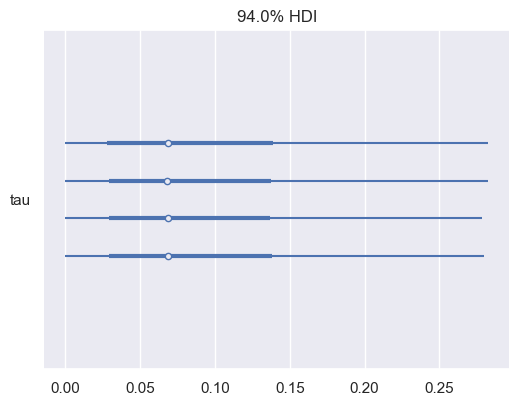

In [8]:
az.plot_forest(trace, var_names=["tau"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

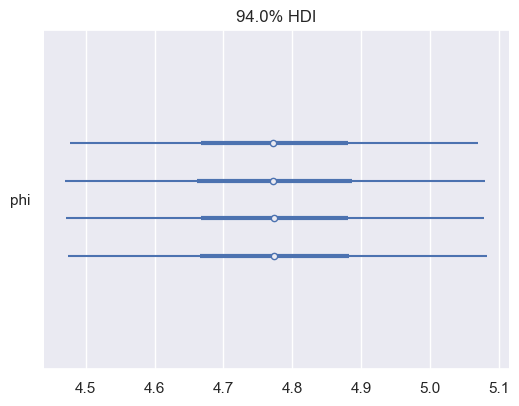

In [9]:
az.plot_forest(trace, var_names=["phi"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

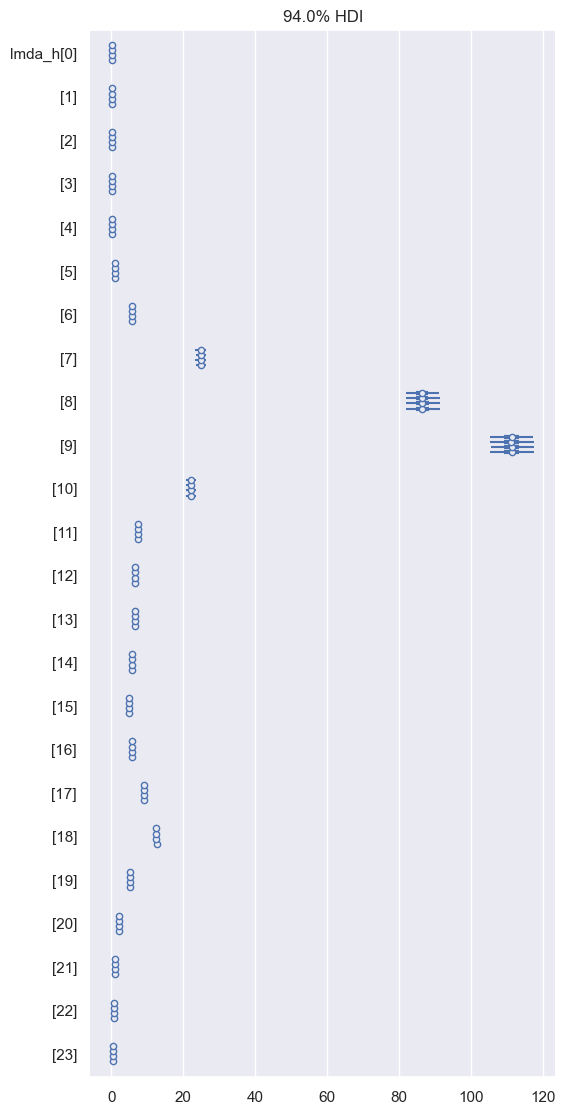

In [10]:
az.plot_forest(trace, var_names=["lmda_h"])

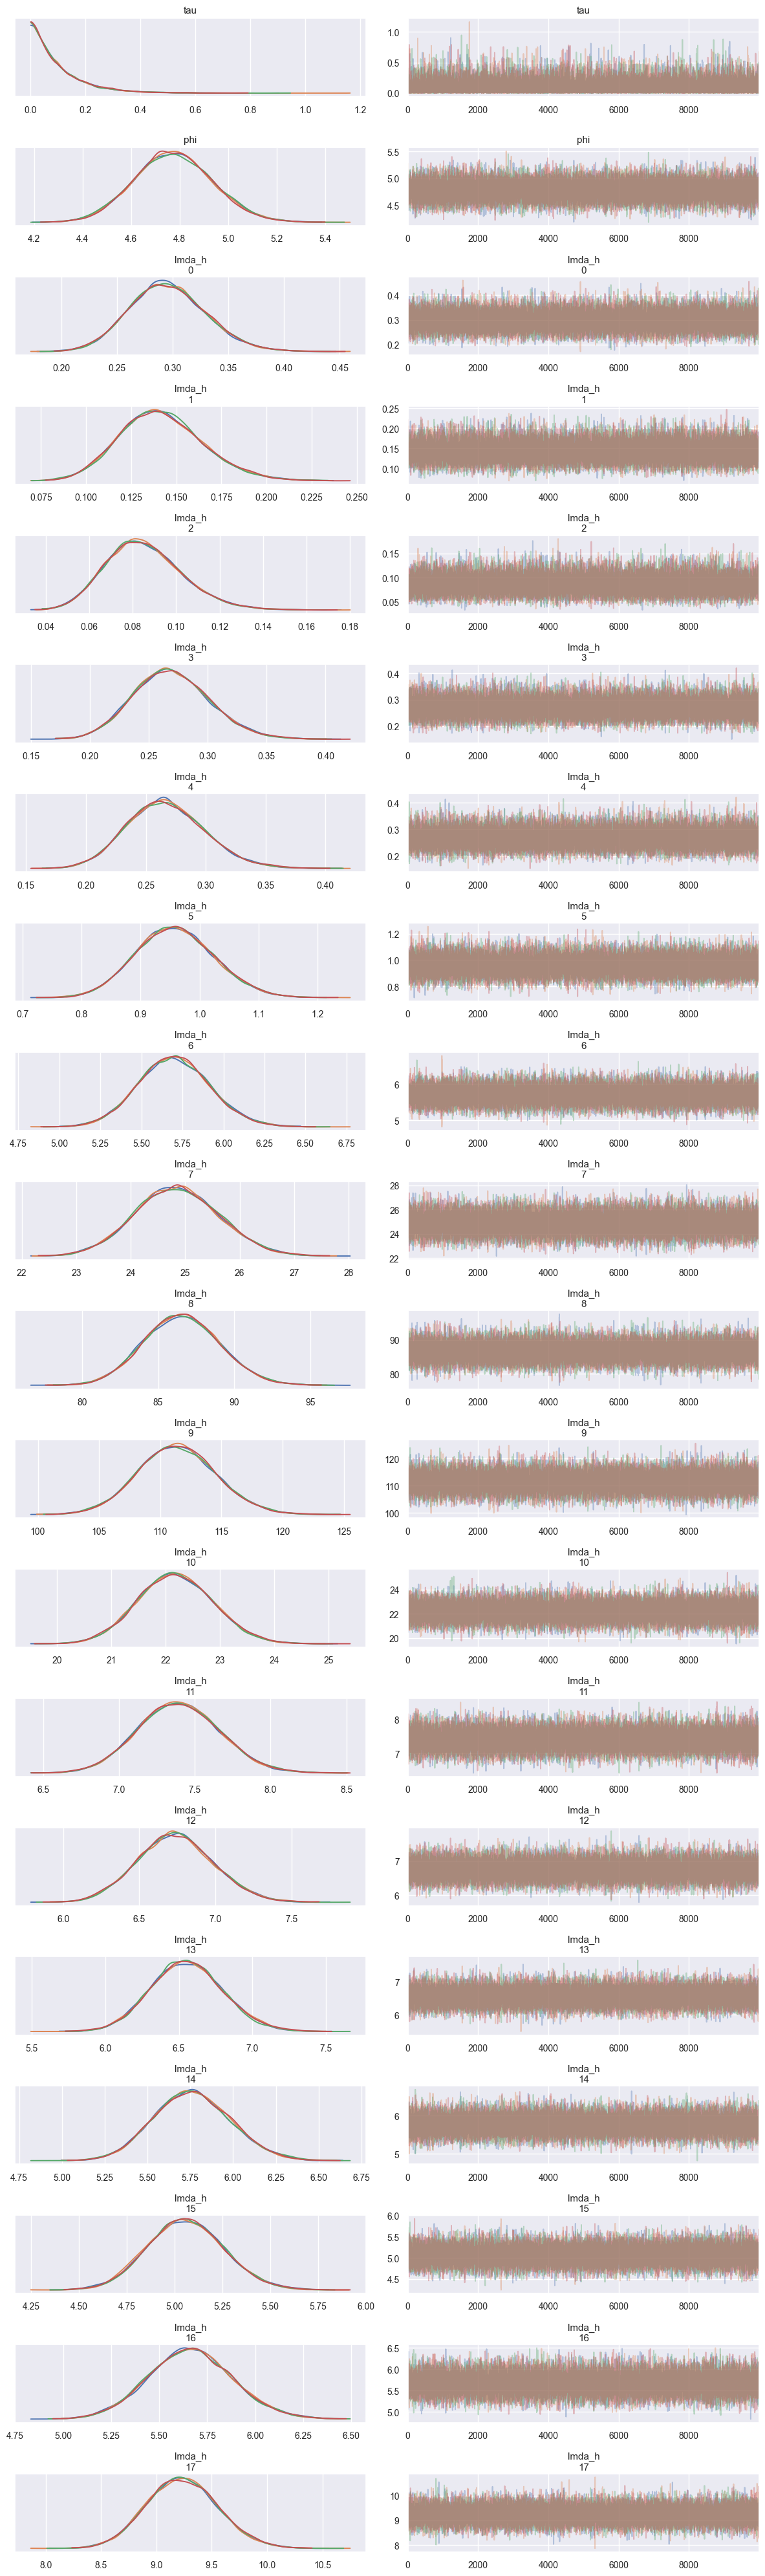

In [11]:
az.plot_trace(trace, compact=False, var_names=["tau", "phi", "lmda_h"]);
plt.tight_layout()

In [12]:
post_preds = np.array(az.extract(trace.posterior_predictive)["c"])

In [37]:
observed_stats = (
    filtered_data.groupby(
        pl.col("hour"), 
        maintain_order=True
    ).agg(
        pl.col("count_outgoing").mean().alias("count_mean"), 
    )
)

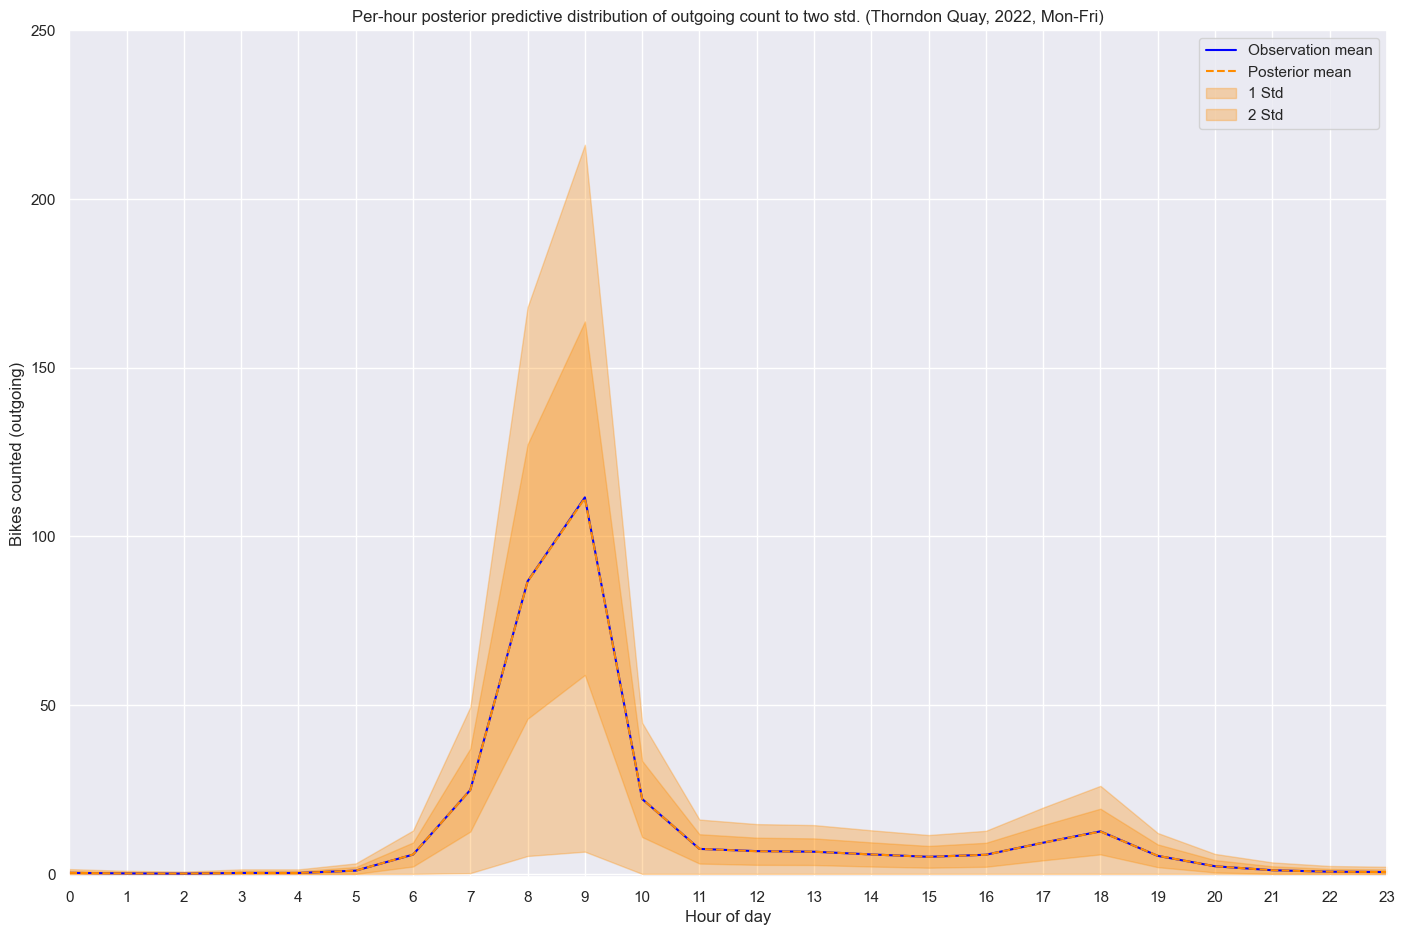

In [40]:
hours = np.arange(24)

obs_mean = observed_stats.select("count_mean").to_numpy().flatten()

post_mean = post_preds[:24].mean(axis=1)
post_std = post_preds[:24].std(axis=1)

plt.plot(hours, obs_mean, label="Observation mean", color="blue")
plt.plot(np.arange(24), post_mean, label="Posterior mean", color="darkorange", linestyle="--")
plt.fill_between(np.arange(24), (post_mean - post_std).clip(min=0), mu + std, alpha=0.3, label="1 Std", color="darkorange")
plt.fill_between(np.arange(24), (post_mean - 2*post_std).clip(min=0), mu + 2*std, alpha=0.3, label="2 Std", color="darkorange")
plt.xticks(np.arange(24))
plt.xlim(0,23)
plt.ylim(-1,250)
plt.xlabel("Hour of day")
plt.ylabel("Bikes counted (outgoing)")
plt.legend()
plt.title("Per-hour posterior predictive distribution of outgoing count to two std. (Thorndon Quay, 2022, Mon-Fri)")
plt.show()

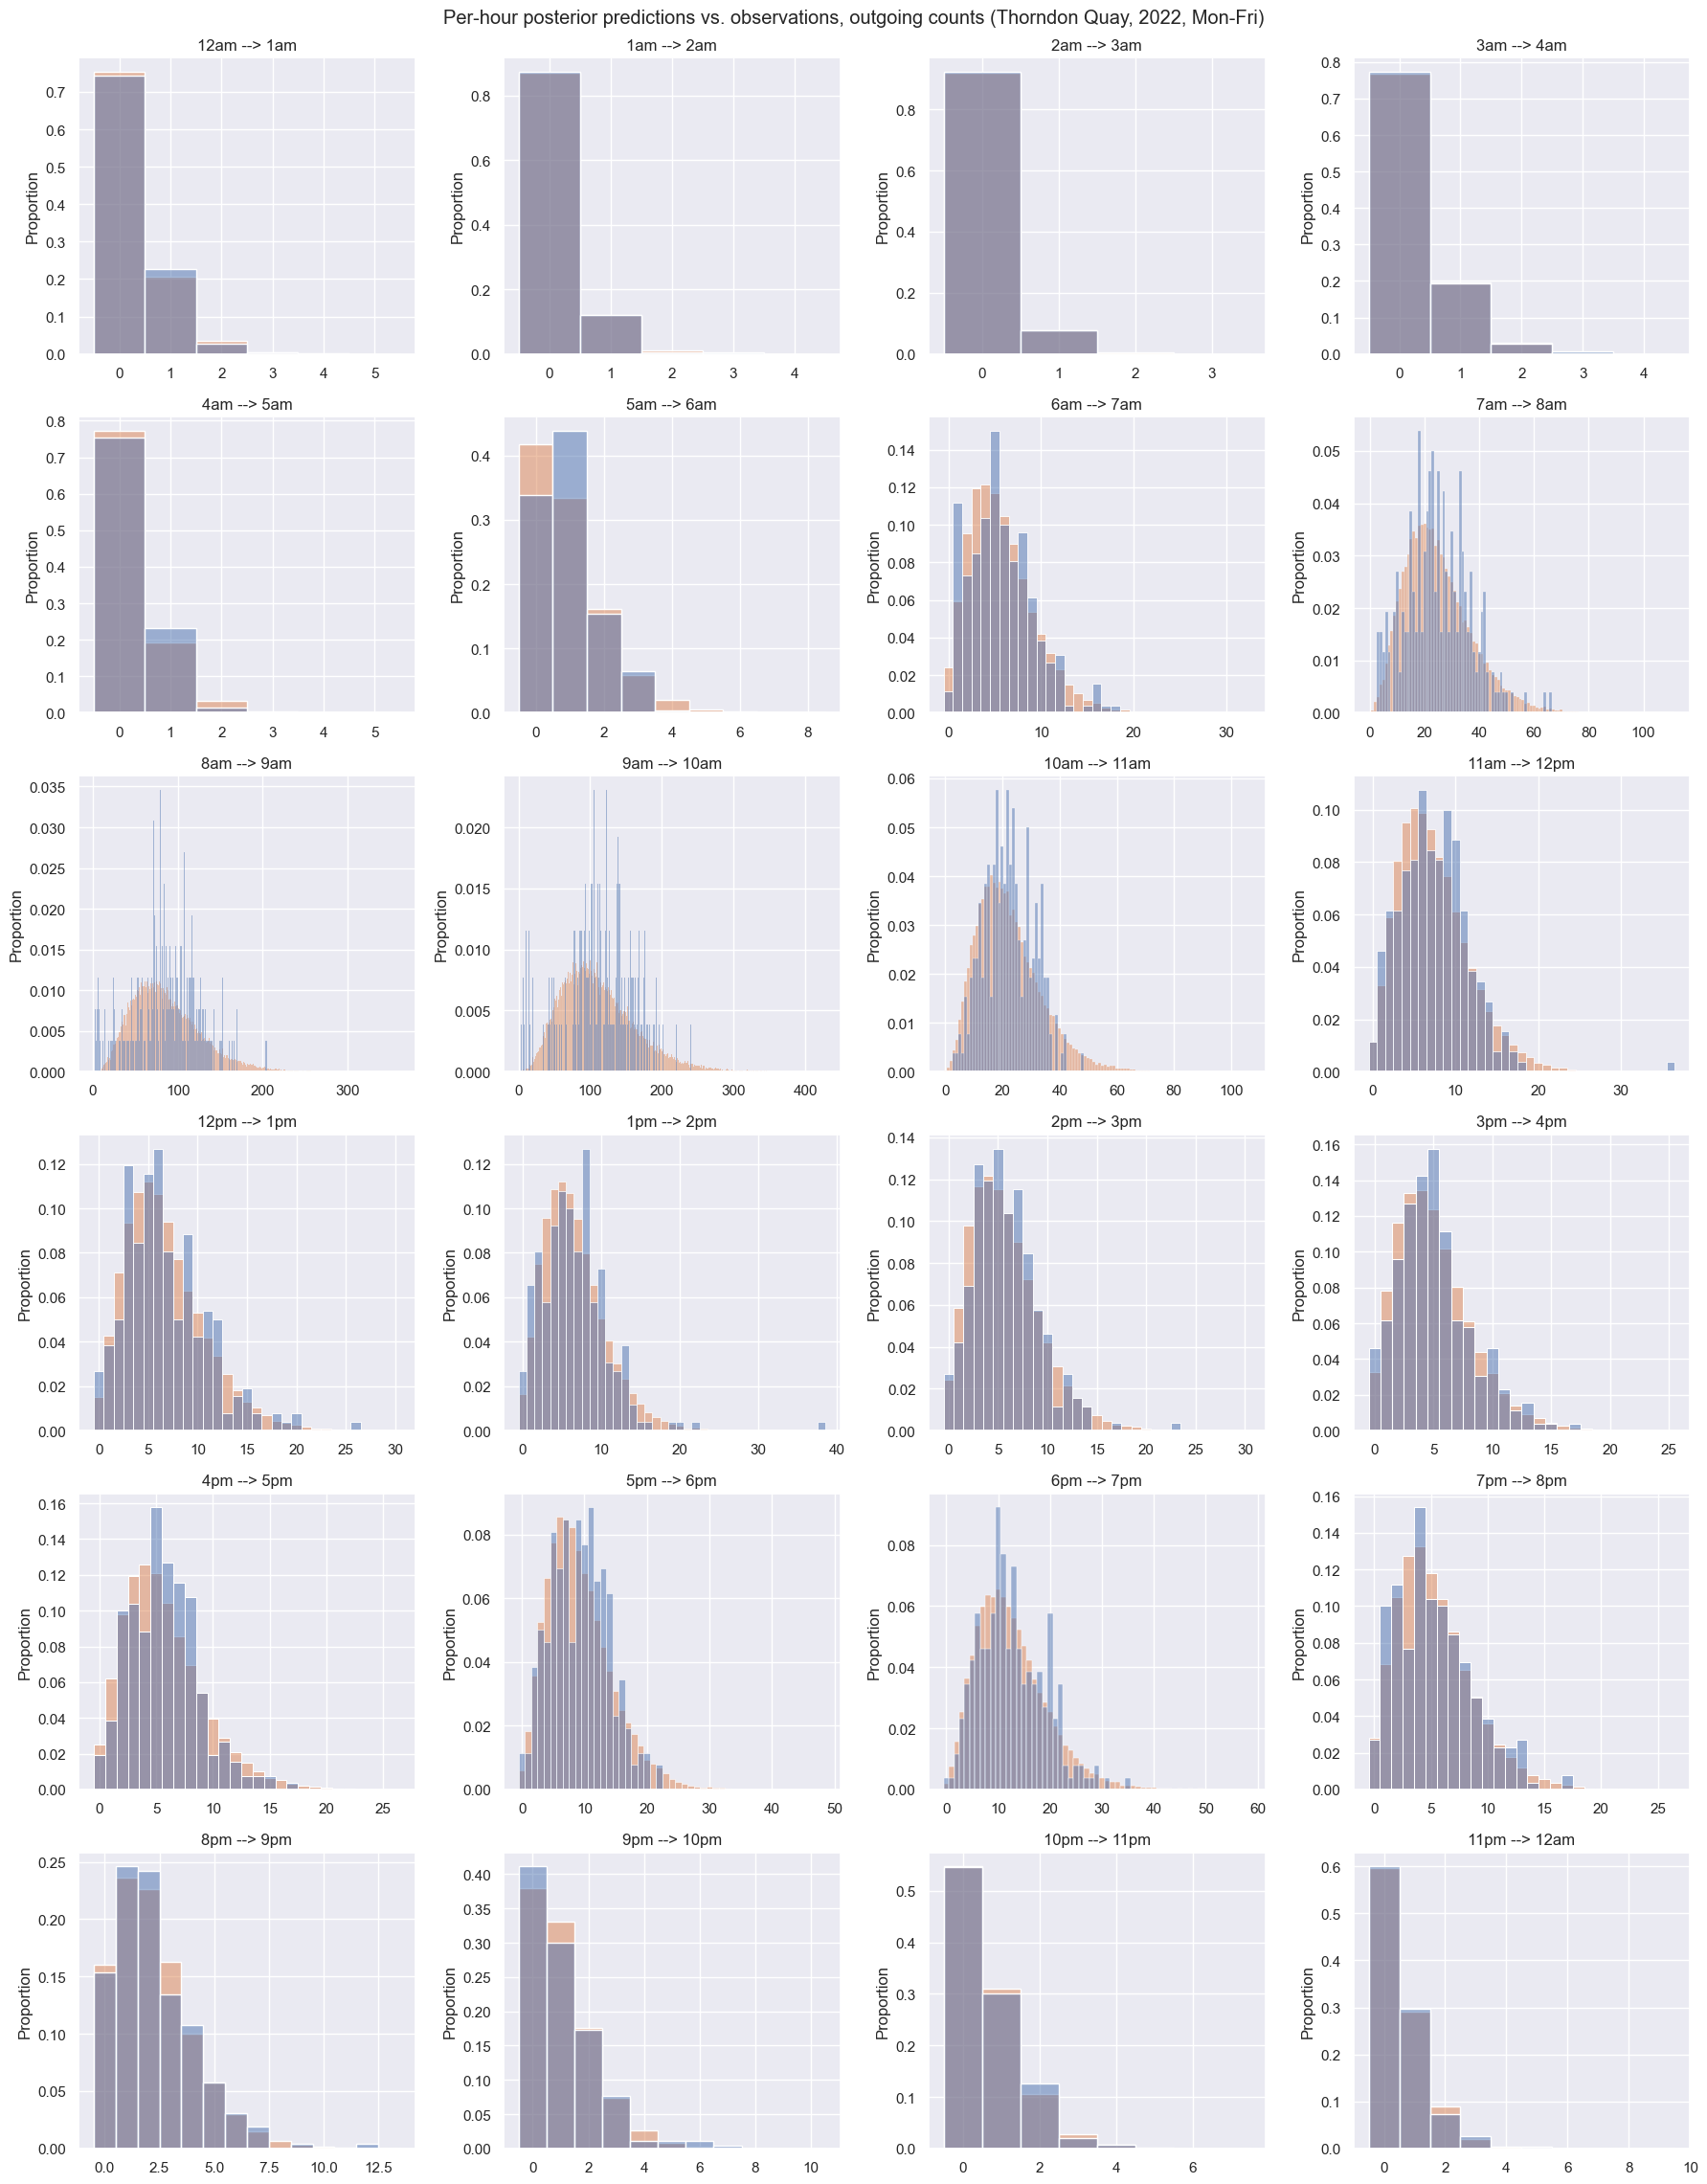

In [14]:
fig, axs = plt.subplots(6, 4, figsize=(18,24))

hour_lookup = np.arange(12)
hour_lookup[0] = 12

for i, hour_df in filtered_data.group_by(pl.col("hour"), maintain_order=True):
    obs = hour_df.select(pl.col("count_outgoing")).to_numpy().flatten()
    post = post_preds[i]
    ax = axs[i//4][i%4]
    sns.histplot([obs, post], discrete=True, stat="proportion", common_norm=False, fill=True, ax=ax, legend=False)
    ampm_0 = "pm" if i // 12 == 1 else "am"
    ampm_1 = "pm" if (i+1) // 12 == 1 else "am"
    ax.set_title(f"{hour_lookup[i % 12]}{ampm_0} --> {hour_lookup[(i+1) % 12]}{ampm_1}")


plt.suptitle("Per-hour posterior predictions vs. observations, outgoing counts (Thorndon Quay, 2022, Mon-Fri)")
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
fig.show()
fig.savefig("tq_oc_per_hour_posterior_pred.png")

In [15]:
# for i, hour_df in filtered_data.group_by(pl.col("hour"), maintain_order=True):
#     obs = hour_df.select(pl.col("count_outgoing")).to_numpy().flatten()
#     post = post_preds[i]
#     g = sns.displot([obs, post], discrete=True, stat="proportion", common_norm=False, fill=True)
#     new_labels = ["Observations", "Posterior predictions"]
#     for t, l in zip(g._legend.texts, new_labels):
#         t.set_text(l)
#     # plt.legend(loc='right', labels=['Observations', 'Posterior predictions'])
#     plt.title(f"Hour: {i}")
#     plt.show()